# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in multiple linear regression , you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The data is from a three link robot:

<img src="https://rst.etit.tu-dortmund.de/storages/rst-etit/r/Media_Forschung/Robotik/Leichtbau/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

The full MERIt dataset can be obtained from the [MERIt site](https://rst.etit.tu-dortmund.de/en/forschung/robotik/leichtbau/details-tudor/#c11560).  But, this dataset is large.  We include only two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

If you are running this notebook on Google colab, you will need to run the following commands to load the files onto your local machine.  Otherwise, you can skip this step.

In [ ]:
import os
from six.moves import urllib

for fn_dst in ['exp1.csv', 'exp2.csv']:
    fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit03_mult_lin_reg/%s' % fn_dst

    if os.path.isfile(fn_dst):
        print('File %s is already downloaded' % fn_dst)
    else:
        print('Downloaded %s' % fn_dst)
        urllib.request.urlretrieve(fn_src, fn_dst)

Downloaded exp1.csv
Downloaded exp2.csv


Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the training data in `exp1.csv`.  Use the `names` option to specify column names of the dataframe

In [ ]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO
df = pd.read_csv('exp1.csv',names=names)

Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [ ]:
# TODO
df.head(6)

,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
1,0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
2,0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
3,0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
4,0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
5,0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.   Label the axes with the units.

Text(0, 0.5, 'I2(degree)')

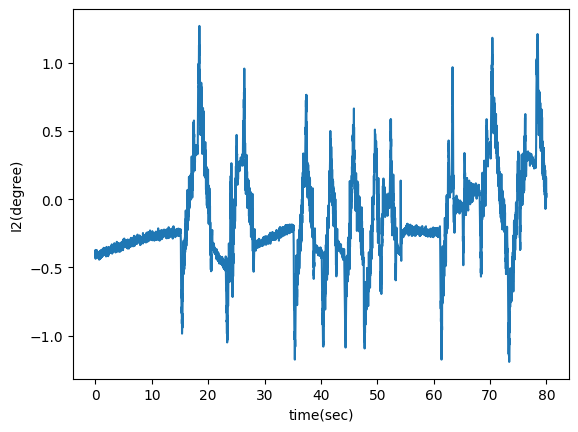

In [ ]:
# TODO
y = df['I2']
t = df['t']
plt.plot(t,y)
plt.xlabel('time(sec)')
plt.ylabel('I2(degree)')


Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`


The difference between a Pandas DataFrame and a Pandas Series lies in their data structure:

#Pandas DataFrame:-
######1- A DataFrame is a two-dimensional, tabular data structure in Pandas.
######2- It is similar to a spreadsheet or a SQL table.
######3- can hold multiple columns with potentially different data types.
######4- Each column in a DataFrame is a Pandas Series.

#Pandas Series:-
######1- A Series is a one-dimensional labeled array in Pandas.
######2- It is essentially a single column of data from a DataFrame.
######3- It has a single data type for all its elements.



######So based on the explanation above ytrain is just one column from the data so it is a pandas series and it is a column of the variable that i want to predict(target).
######And Xtrain is pandas data frame cause it has multiple columns and those columns are the features(thing that affects the target)

######The shape of ytrain is (8000,) which means there is 8000 rows and this is the number of different values that we measured or the number of examples and 1 column which we already inserted from the data frame('I2')
######And the shape of Xtrain is (8000,7) is the 8000 examples for the 7 features(columns)

In [ ]:
# TODO
ytrain = df['I2']
Xtrain = df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
print(type(ytrain))
print(type(Xtrain))
print(ytrain.shape)
print(Xtrain.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
(8000,)
(8000, 7)


## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` object `regr`.

###The line of code regr = linear_model.LinearRegression() creates an instance of a linear regression model in Python, typically using a library like scikit-learn (sklearn). Let's break it down in detail:

######linear_model: This is a module or subpackage within scikit-learn (a popular machine learning library in Python) that contains various linear models, including linear regression.

####LinearRegression(): This is a constructor or function call that initializes a linear regression model. Here's what it does:

######1- Linear Regression: Linear regression is a supervised machine learning algorithm used for modeling the relationship between a dependent variable (target) and one or more independent variables (features or predictors). It assumes a linear relationship between the variables, where the goal is to find the best-fitting linear equation that explains the relationship.

######2- Model Initialization: When you call LinearRegression(), you create an instance of a linear regression model. This instance (referred to as regr in code) is an object that can be used to perform various operations related to linear regression.

###Attributes and Methods: The regr object comes with attributes and methods that allow you to:

Fit the model to your training data using the fit method.
Make predictions on new data using the predict method.
Access coefficients, intercepts, and other model parameters.
Evaluate the model's performance (e.g., calculating R-squared or Mean Squared Error).

In [ ]:
from sklearn import linear_model

# Create linear regression object
# TODO
regr = linear_model.LinearRegression()

Train the model on the training data.

In [ ]:
# TODO
regr.fit(Xtrain,ytrain)

LinearRegression()

Using the trained model, compute, `ytrain_pred`, the predicted current.  Plot `ytrain_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

Text(0, 0.5, 'I2')

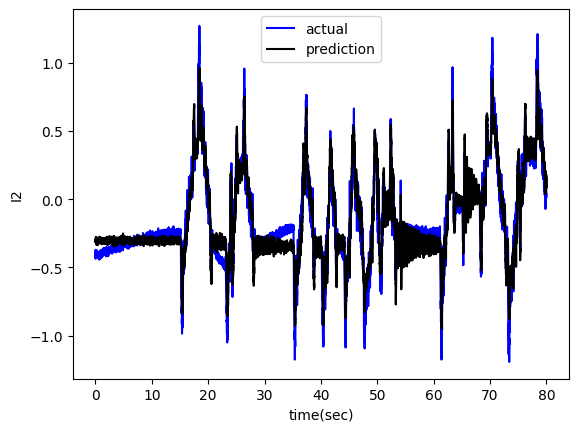

In [ ]:
# TODO
ytrain_pred = regr.predict(Xtrain)
ytrain_pred = regr.predict(Xtrain)
plt.plot(t,ytrain,color='blue')
plt.plot(t,ytrain_pred,color='black')
plt.legend(['actual','prediction'])
plt.xlabel('time(sec)')
plt.ylabel('I2')

Measure the normalized RSS given by `RSS / (n s^2_y).

RSS is the summation of the squre difference of y_predicted and y_actual and we divide by n so this is the mean(summation all of them divided by their number) and numpy provide mean function and we divide also by the variance of y_actual but np just provide standard deviation function so we square it

In [ ]:
# TODO
RSS_train = (np.mean((ytrain-ytrain_pred)**2))/(np.std(ytrain)**2)
print(RSS_train)

0.09583263861233197


## Measure the Fit on an Indepdent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test model on independent data not used in the training.  For this purpose, load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

Now we will test our model we have already trained it testing steps is the same as the train we ask our model to predict the value of the examples in the test set but the key difference that these examples in the test he did not see before so we can measure the performance of our model on new examples(this is not the best thing we can do but for now it is enough)

Text(0, 0.5, 'I2')

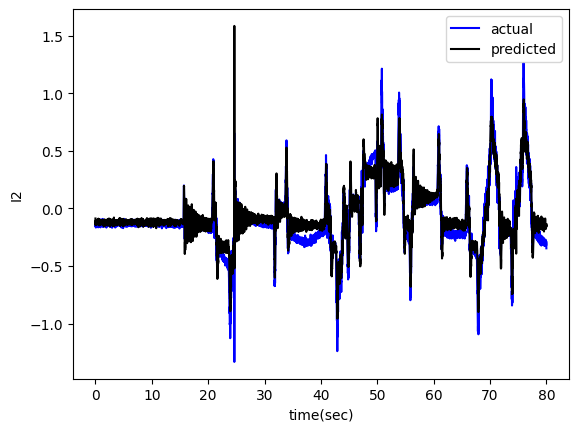

In [ ]:
# TODO
#we put the examples in exp2 file in data frame as our test set
df2=pd.read_csv('exp2.csv',names=names)
X_test=df2[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']]
y_test=df2['I2']
#we ask our linear regression object that we created to predict the new examples without calling the fit function cause we do not want the model to train these new examples
y_predict=regr.predict(X_test)


#we plot the real value of the new examples and the prediction of our model on them without training on them they are totally new examples for our model
t=df2['t']
plt.plot(t,y_test,color='blue')
plt.plot(t,y_predict,color='black')
plt.legend(['actual','predicted'])
plt.xlabel('time(sec)')
plt.ylabel('I2')

Measure the normalized RSS on the test data.

In [ ]:
# TODO
RSS_test = (np.mean((y_test-y_predict)**2))/(np.std(y_test)**2)
print(RSS_test)

0.12678048804762448


In [ ]:
# this line conver it to html
!jupyter nbconvert --to html LAB1.ipynb

[NbConvertApp] WARNING | pattern 'LAB1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut